<a href="https://colab.research.google.com/github/y4c6/master_thesis/blob/main/EJMR_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install gensim==4.3.0

In [ ]:
#!pip install --upgrade numpy

In [1]:
import numpy as np
import pandas as pd
import json

In [2]:
from google.colab import drive
# directory
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## preparing data

In [3]:
import glob
import json

def list_json_files(path, start_with): 
    # get a list of json files that starts with specific word 
    json_files = glob.glob(path + f'/{start_with}*.json')
    return json_files

def concat_json_files(file_paths):
    # concatenate the content of all the files in the list
    data = {'topic':[], 'posts':[]}
    for file_path in file_paths:
        with open(file_path, 'r') as f:
            file_data = json.load(f)
            data['topic'].extend(file_data['topic'])
            data['posts'].extend(file_data['posts'])
    return data

def concat_json_files_with_start(path, start_with):
    json_files = list_json_files(path, start_with)
    data = concat_json_files(json_files)
    return data


In [72]:
path = '/content/gdrive/MyDrive/論文相關材料/'
start_with = 'EJMRpost_'
data = concat_json_files_with_start(path, start_with)

In [ ]:
len(data['topic'])

150000

In [ ]:
## construct the dictionary to dataframe

In [73]:
df = pd.DataFrame(data)
df.head(3)

,topic,posts
0,https://www.econjobrumors.com/topic/rbb-or-kari,"[Whose more of a dishonest cringe dooshbag?, I..."
1,https://www.econjobrumors.com/topic/as-ian-ame...,[https://www.nytimes.com/2022/03/06/nyregion/a...
2,https://www.econjobrumors.com/topic/russia-chi...,[Is this the genius outcome the West was looki...


In [8]:
df.to_pickle("./ejmr_20.pkl")

In [9]:
unpickled_df = pd.read_pickle("./ejmr_20.pkl")  
unpickled_df.head(3)

,topic,posts
0,https://www.econjobrumors.com/topic/rbb-or-kari,"[Whose more of a dishonest cringe dooshbag?, I..."
1,https://www.econjobrumors.com/topic/as-ian-ame...,[https://www.nytimes.com/2022/03/06/nyregion/a...
2,https://www.econjobrumors.com/topic/russia-chi...,[Is this the genius outcome the West was looki...


## select out the asian-related posts

In [6]:
asia_target = ['asian', 'asia', 'korea', 'korean', 'japan', 'japanese', 'taiwan', 'taiwanese', 'east', 'hongkong']
china_target = ['china', 'chinese']

In [74]:
# Defining all the conditions inside a function
def condition(x):
    if any( word in x for word in asia_target): #series.str.contains('Mel').any()
        return "asia"
    elif any( word in x for word in china_target):
        return "china"
    else:
        return "other"
 
# Applying the conditions
df['Target'] = df['topic'].apply(condition)
df.head(3)

,topic,posts,Target
0,https://www.econjobrumors.com/topic/rbb-or-kari,"[Whose more of a dishonest cringe dooshbag?, I...",other
1,https://www.econjobrumors.com/topic/as-ian-ame...,[https://www.nytimes.com/2022/03/06/nyregion/a...,other
2,https://www.econjobrumors.com/topic/russia-chi...,[Is this the genius outcome the West was looki...,china


In [ ]:
( len(df[df['Target']=='china']) + len(df[df['Target']=='asia']) )/ len(df[df['Target']=='other'])

0.033271337053110146

In [ ]:
len(df[df['Target']=='china']) / (len(df[df['Target']=='china']) + len(df[df['Target']=='asia']))

0.5534161490683229

In [ ]:
len(df[df['Target']=='china']) / len(df[df['Target']=='asia'])

1.239221140472879

In [51]:
len(df[df['Target']=='china']) + len(df[df['Target']=='asia'])

4830

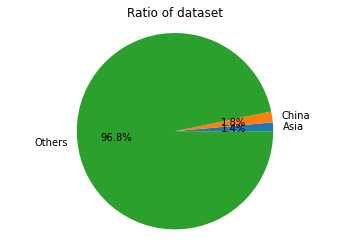

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Asia', 'China', 'Others'
sizes = [len(df[df['Target']=='asia']), len(df[df['Target']=='china']), len(df[df['Target']=='other'])]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Ratio of dataset")
plt.show()

## Prepare y

In [11]:
df = df.drop(df[df['Target'] == 'other'].index)
df.head(3)

,topic,posts,Target
2,https://www.econjobrumors.com/topic/russia-chi...,[Is this the genius outcome the West was looki...,china
23,https://www.econjobrumors.com/topic/are-more-t...,"[Not even accounting for Indians., All the qua...",asia
44,https://www.econjobrumors.com/topic/reminder-c...,"[Never forget. Never forgive., .]",china


In [12]:
df['y'] = df['Target'].apply(lambda x: 1 if x == 'china' else 0)
df.head(3)

,topic,posts,Target,y
2,https://www.econjobrumors.com/topic/russia-chi...,[Is this the genius outcome the West was looki...,china,1
23,https://www.econjobrumors.com/topic/are-more-t...,"[Not even accounting for Indians., All the qua...",asia,0
44,https://www.econjobrumors.com/topic/reminder-c...,"[Never forget. Never forgive., .]",china,1


## Prepare X

In [13]:
import nltk
nltk.download('punkt') #this is download for tonkenizer
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Define a function to preprocess text
def preprocess_text(text):
  # Lowercase all characters
  text = text.lower()

  # Remove URLs
  text = re.sub(r'https?://\S+', '', text)

  # Remove digits
  text = text.translate(str.maketrans('', '', string.digits))

  # Remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))

  return text

# Define a function to tokenize and remove stopwords from text
def tokenize_and_remove_stopwords(text):
  # Tokenize the article
  text_tokens = word_tokenize(text)

  # Load English stopwords
  stop_words = set(stopwords.words('english'))

  # Remove stopwords
  tokens = [token for token in text_tokens if token not in stop_words]

  return tokens

In [29]:
## check library
import gensim

## ignore warnings
import warnings
warnings.filterwarnings('ignore')

# # if you want to see the training messages, you can use it
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## the input type
df['text_tokenized'] = df['posts'].apply(lambda x: tokenize_and_remove_stopwords(preprocess_text( ' '.join(x) ))) 
df[['y', 'text_tokenized']].head(3)

,y,text_tokenized
2,1,"[genius, outcome, west, looking, russian, fina..."
23,0,"[even, accounting, indians, quant, clubs, univ..."
44,1,"[never, forget, never, forgive]"


In [30]:
## create the training corpus
corpus = df['text_tokenized'].values
corpus[0][:5]

['genius', 'outcome', 'west', 'looking', 'russian']

## Word-embedding (Word2vec) & Topic Modelling (LDA)

It is worth noting that this method is not widely used and there are other ways to combine LDA and word2vec such as using word2vec vectors as priors for LDA or using LDA topics as features for word2vec.
Also, LDA is unsupervised method while word2vec is supervised method, so the way you combine them is important and it depends on your application.
It is recommended to consult with experts in this field and validate the results to see whether this approach is beneficial for your task or not.

In [ ]:
gensim.__version__

'3.6.0'

In [ ]:
# !pip install --upgrade gensim

### Word2Vec

In [ ]:
from gensim.models import Word2Vec

## setting
vector_dim = 100
window_size = 5
min_count = 1
training_epochs = 20

## model
word2vec_model = Word2Vec(sentences=corpus, size=vector_dim) #, window=window_size, min_count=min_count, epochs=training_epochs)

In [ ]:
# Get the most similar words
word = 'china'
topn = 30
w2v_china = pd.DataFrame(word2vec_model.wv.most_similar(word, topn=topn))
w2v_china.columns = ['Word', 'Sims']

w2v_china.head(3)

,Word,Sims
0,territory,0.808221
1,invade,0.798980
2,tibet,0.798434
3,island,0.798132
4,facto,0.779776
5,nukes,0.775288
6,roc,0.772613
7,belongs,0.772110
8,invasion,0.771001
9,lost,0.763442


In [ ]:
# Get the most similar words
word = 'chinese'
topn = 30
w2v_asia = pd.DataFrame(word2vec_model.wv.most_similar(word, topn=topn))
w2v_asia.columns = ['Word', 'Sims']

w2v_asia.head(3)

,Word,Sims
0,sympathizers,0.712218
1,taiwanese,0.669642
2,han,0.666017
3,korean,0.660809
4,hold,0.637837
5,twers,0.635374
6,distrust,0.624216
7,brainwashed,0.622997
8,nationality,0.622318
9,japanese,0.621930


### LDA

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a matrix using CountVectorizer
cv = CountVectorizer(preprocessor = preprocess_text, 
            tokenizer = tokenize_and_remove_stopwords, 
            max_features = 10000)

In [22]:
data_matrix = cv.fit_transform(df['posts'].apply(lambda x: ' '.join(x)))

# Print the matrix
print(data_matrix.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


use LDA from sklearn

In [23]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(data_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [24]:
for i,topic in enumerate(LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    print([cv.get_feature_names()[index] for index in topic.argsort()[-10:]])

TOP 10 WORDS PER TOPIC #0


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['people', 'like', '’', 'culture', 'japan', 'japanese', 'korean', 'china', 'korea', 'chinese']
TOP 10 WORDS PER TOPIC #1
['know', 'email', 'would', 'anyone', 'test', 'got', 'one', 'offer', 'u', 'w']
TOP 10 WORDS PER TOPIC #2
['americans', 'get', 'would', 'dont', 'us', 'asians', 'like', 'people', '’', 'asian']
TOP 10 WORDS PER TOPIC #3
['’', 'dont', 'get', 'like', 'china', 'people', 'good', 'us', 'students', 'chinese']
TOP 10 WORDS PER TOPIC #4
['world', 'like', 'ccp', 'taiwan', 'would', 'people', '’', 'chinese', 'us', 'china']


use LDA from gensim

In [31]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(df['text_tokenized'])

# Create Corpus
texts = df['text_tokenized']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [35]:
corpus[0][:15]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 3),
 (5, 3),
 (6, 2),
 (7, 1),
 (8, 2),
 (9, 1),
 (10, 3),
 (11, 2),
 (12, 1),
 (13, 2),
 (14, 1)]

In [46]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]][0][:15]

[('action', 1),
 ('actually', 1),
 ('agree', 1),
 ('aid', 1),
 ('al', 3),
 ('allies', 3),
 ('ally', 2),
 ('alone', 1),
 ('already', 2),
 ('also', 1),
 ('alternatives', 3),
 ('always', 2),
 ('anything', 1),
 ('arent', 2),
 ('assumed', 1)]

In [49]:
from gensim.models import LdaModel

# Train the model on the corpus.
lda = LdaModel(corpus,
        id2word=id2word,
        num_topics=10, 
        random_state=42)

In [50]:
lda.print_topics(num_topics=10, num_words=10)

[(0,
  '0.011*"chinese" + 0.010*"people" + 0.007*"china" + 0.007*"’" + 0.006*"like" + 0.005*"dont" + 0.005*"would" + 0.004*"us" + 0.004*"even" + 0.004*"korea"'),
 (1,
  '0.026*"china" + 0.017*"us" + 0.007*"people" + 0.007*"chinese" + 0.007*"would" + 0.006*"country" + 0.006*"’" + 0.006*"world" + 0.005*"like" + 0.005*"ccp"'),
 (2,
  '0.009*"people" + 0.008*"chinese" + 0.007*"’" + 0.007*"asian" + 0.006*"dont" + 0.005*"china" + 0.005*"women" + 0.005*"one" + 0.005*"even" + 0.004*"also"'),
 (3,
  '0.017*"china" + 0.010*"chinese" + 0.006*"’" + 0.005*"people" + 0.005*"good" + 0.004*"like" + 0.004*"also" + 0.004*"covid" + 0.004*"one" + 0.004*"know"'),
 (4,
  '0.010*"’" + 0.008*"people" + 0.007*"china" + 0.006*"chinese" + 0.005*"like" + 0.004*"dont" + 0.004*"country" + 0.003*"”" + 0.003*"asian" + 0.003*"“"'),
 (5,
  '0.010*"japan" + 0.008*"like" + 0.008*"people" + 0.007*"’" + 0.005*"asian" + 0.005*"get" + 0.004*"think" + 0.004*"japanese" + 0.004*"china" + 0.004*"chinese"'),
 (6,
  '0.020*"china"